In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import argparse
# import utils
import cv2
import numpy as np
from collections import Counter
import colorsys
from PIL import ImageEnhance
from PIL import Image
%matplotlib inline

In [2]:
def quantization(image,n_clusters):
    w, h, _ = image.shape
    print('cluster_to_',n_clusters)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    clt = KMeans(n_clusters = n_clusters)
    clt = clt.fit(image)
    center = clt.cluster_centers_.astype("uint8")
   
    img = center[clt.labels_]    
    img = img.reshape((w, h, 3)).astype("uint8")
    #img[np.where((edge_image==(0,0,0)).all(axis=-1))] = (0,0,0) 
    return clt,img

def centroid_histogram(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

def color_clustering(hist, centroids,n_clusters):
    centroids = centroids.astype("uint8").tolist() 
    colorDic = {p : c for p, c in zip(hist, centroids)} #{"사용비율 : 색깔"}
    colorDic = sorted(colorDic.items(), key=lambda x:x[0], reverse=True)
   
    #flag = np.empty((1,n_clusters,3), dtype=np.uint8) 
    i = 0
    per=[]
    hsv =[]
    for (percent, color) in colorDic: 
        a = colorsys.rgb_to_hsv(color[0],color[1],color[2]) #hsv로 저장   
        hsv.append(list(a))
        per.append(round(percent,2)) 
        #flag[0,i,:] = color
        i+=1   
       
    return per,hsv #사용비율, hsv


def colorextract(img):
    sample = cv2.imread(img)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
    sample = cv2.resize(sample, dsize=(512, 512), interpolation=cv2.INTER_AREA)
    sample[np.where((sample>=(230,230,230)).all(axis=-1))] = (255,255,255) 
    
    #채도 조정
    hsv = cv2.cvtColor(sample,cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*1.2
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
   
    hsv = np.array(hsv, dtype = np.uint8)
    image=cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    
    out = np.ones_like(image) *255
    mask = np.ones((512,512), dtype='uint8') * 0
    cv2.circle(mask, (256, 256), 255, 3, -1)
    cv2.grabCut(image ,mask,None,None,None,3,cv2.GC_INIT_WITH_MASK)
    out[np.where((mask==3))] = image[np.where((mask==3))]
  
    cv2.imwrite('out.jpg', cv2.cvtColor(out,cv2.COLOR_BGR2RGB))
   
    
    #대비 높임
#     lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB) 
#     l, a, b = cv2.split(lab) 
#     clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(8, 8)) 
#     cl = clahe.apply(l) 
#     limg = cv2.merge((cl, a, b)) 
#     image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    #만다라부분 crop -> 흰배경에 붙임
   
    
    CLUSTER = 10
    clt,final = quantization(out, CLUSTER)
    hist = centroid_histogram(clt)
    hist = hist.astype("float")

    per,hsv = color_clustering(hist, clt.cluster_centers_,CLUSTER) #많이 쓰인 순서대로 나옴
    hsvlist = list(zip(per, hsv))
    hsvlist=sorted(hsvlist, key = lambda x: (x[0]),reverse=True) #채도 명도 곱한거 기준으로 내림차순, 혹시 같은 값이면 칠해진 부분이 많은 순서 #x[1][2]*x[1][1]

    rgblist=[]
    graylist = []
    for per,color in hsvlist:
        if (color[1]<0.13 and color[2]<=150) or (color[1]<0.1 and color[2]>=250):
            print('g',color,per)
            g = colorsys.hsv_to_rgb(color[0],color[1],color[2])
            g = list(g)
            graylist.append(g)
            
        else:
            a = colorsys.hsv_to_rgb(color[0],color[1],color[2])
            a = list(a)
            print('a',color,per)
            rgblist.append(a)
                    
    return rgblist, graylist

def show(colors):
    clist = colors
    flag = np.empty((1,17,3), dtype=np.uint8) 
    i = 0
    if len(clist)<17:
        clist[len(clist):17]=[[255,255,255]]*(17-len(clist))
    for rgb in clist:
        flag[0,i,:] = rgb
        i+=1
    plt.axis("off")
    plt.imshow(flag)

In [3]:
clist,glist = colorextract('./coloring_result/OKT_0.jpg') 

cluster_to_ 10
g [0.0, 0.0, 254] 0.76
a [0.6379310344827586, 0.12831858407079647, 226] 0.04
g [0.9, 0.07246376811594203, 69] 0.04
g [0.641025641025641, 0.12380952380952381, 105] 0.04
a [0.8333333333333334, 0.14130434782608695, 184] 0.03
a [0.2111111111111111, 0.2054794520547945, 146] 0.03
a [0.1638888888888889, 0.2727272727272727, 220] 0.02
a [0.5981182795698925, 0.5767441860465117, 215] 0.01
a [0.08589743589743588, 0.6018518518518519, 216] 0.01
a [0.008771929824561412, 0.7150537634408602, 186] 0.01


In [4]:
clist

[[197.0, 202.0, 226],
 [184, 158.0, 184.0],
 [138.0, 146, 116.00000000000001],
 [220, 219.0, 160.0],
 [90.99999999999999, 141.99999999999997, 215],
 [216, 152.99999999999997, 86.0],
 [186, 60.00000000000001, 52.99999999999999]]

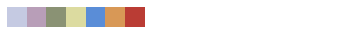

In [5]:
show(clist)

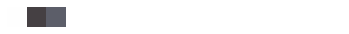

In [6]:
show(glist)

In [24]:
def brightness(img, val):
    value = val
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

In [25]:
img = cv2.imread('pink.jpg')
img = brightness(img, 1.2)
cv2.imshow('Result', img)
cv2.waitKey(0)
cv2.destroyAllWindows()